# Experiment #2 - Feature Engineering

## Overview

The purpose of this notebook is to improve the performance of the baseline model by creating derived features for the best classifier. So, our first task is to analyze the predictions from the baseline model.

In [1]:
%load_ext autoreload
%autoreload 2

from utils import code
from plot_libraries import setup_graphics
from datasets import get_data

In [2]:
#Main Libraries
import os, random, re, sys, warnings
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from joblib import load

#utils
from plot_libraries import setup_graphics, dist_plot

#corr matrix
from scipy.stats import spearmanr
from scipy.cluster import hierarchy
from sklearn.inspection import permutation_importance

#Data transform (pipeline)
from sklearn.preprocessing import OneHotEncoder, FunctionTransformer, LabelEncoder, OrdinalEncoder
from sklearn.preprocessing import MinMaxScaler,RobustScaler
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline, FeatureUnion
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.calibration import CalibratedClassifierCV



# Model evaluation
import scikitplot as skplt
from sklearn.metrics import make_scorer, roc_auc_score, brier_score_loss, classification_report, confusion_matrix
from sklearn.model_selection import train_test_split, cross_val_predict
from evaluation import plot_learning_curve, evaluate_model, plot_confusion_matrix, evaluate_model_skopt 
from evaluation import plot_feature_permutation, plot_calibration_curve, get_cv_scores
from skopt import BayesSearchCV
from skopt.space import Real, Categorical, Integer

# Support
import parameters as params
from model import Model, build_tuned_model
from datasets import get_data
from experiments import experiment_1, experiment_2, get_scorer
from sklearn.metrics import make_scorer, roc_auc_score, brier_score_loss, classification_report, confusion_matrix

#setup
warnings.filterwarnings("ignore")
pd.options.display.max_columns = None
sns.set()
%matplotlib inline
setup_graphics()

In [3]:
X, y = get_data('../data/trainDF.csv')
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=.2, stratify=y, random_state=20)

In [4]:
model = Model.load('../models_pkl/experiment-1-model.pkl')
pipeline1 = experiment_1.get_full_pipeline()

We noticed that the feature importance of our model is biased due 2 reasons:

* `Activities_Last_30_Days`: Has a leaky beahaviour and must be removed in order to does not harn predictions od future data

* High correlated variables which decrease the importance amog them.

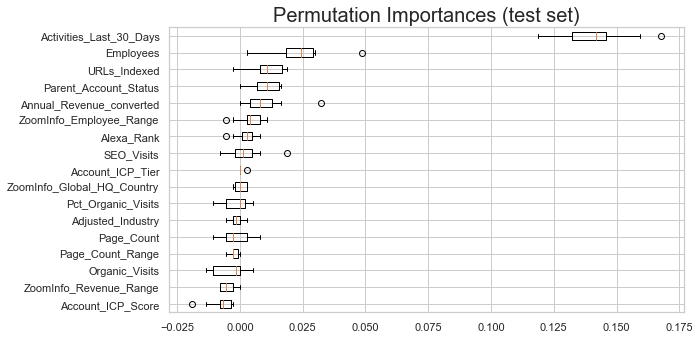

In [5]:
plot_feature_permutation(pipeline1, model.model, X_train, y_train, X_test, y_test)

Now we can take a look into a hierarchical clustering to find which pairs of features are correlated.

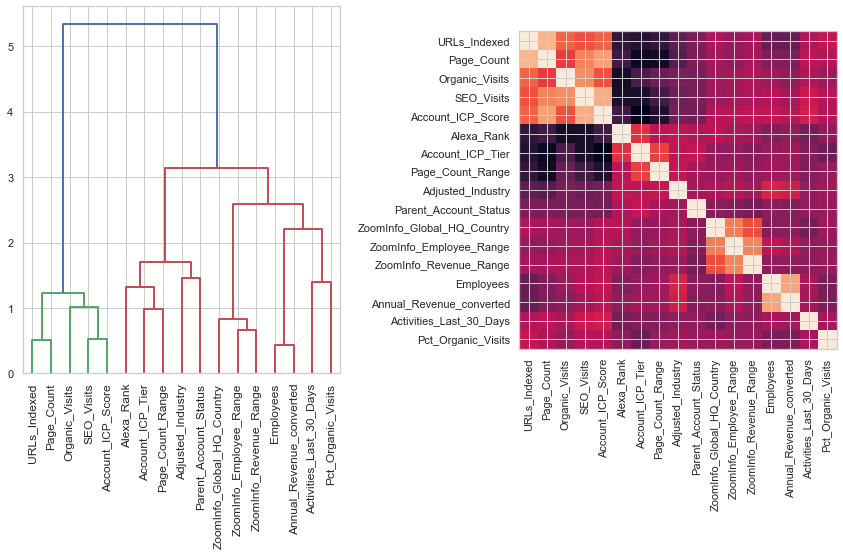

In [6]:
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 8))
corr = spearmanr(X).correlation
corr_linkage = hierarchy.ward(corr)
dendro = hierarchy.dendrogram(corr_linkage, labels=X.columns, ax=ax1, leaf_rotation=90)
dendro_idx = np.arange(0, len(dendro['ivl']))

ax2.imshow(corr[dendro['leaves'], :][:, dendro['leaves']])
ax2.set_xticks(dendro_idx)
ax2.set_yticks(dendro_idx)
ax2.set_xticklabels(dendro['ivl'], rotation=90)
ax2.set_yticklabels(dendro['ivl'])
fig.tight_layout()
plt.show()

* The following features will be removed:
`Organic_Visits`, `Page_Count`, `Annual_Revenue_converted`, `ZoomInfo_Employee_Range`.

Due some reasons such as more incidence of nan values, data reliability and feature importance.

#### Category Encoders

Rather than doing one hot encoder as done in exp1, we will try a new approach using some other techniques of category enconders. We can give up some performance in order to have some interpretability (shap values).

* `ZoomInfo_Employee_Range`: OrdinalEncoder(mapping=MAP_ORDINAL)
* `ZoomInfo_Global_HQ_Country`: BinaryEncoder()
* `Adjusted_Industry`: CatBoostEncoder()
* `Account_ICP_Tier`: OrdinalEncoder() 
* `Page_Count_Range`: OrdinalEncoder(mapping=MAP_ORDINAL)
* `Parent_Account_Status`: OrdinalEncoder(mapping=MAP_ORDINAL)

### Pipeline Experiment 2

In [7]:
pipeline2 = experiment_2.get_full_pipeline()
ps = pipeline2.fit_transform(X_train).shape
print('Instances: {:,}, Features: {}'.format(ps[0], ps[1]))

Instances: 1,479, Features: 12


In [8]:
#setup
scorer = make_scorer(roc_auc_score)
results, res_cv, res_calibrated, n_iter = list(), dict(), dict(), 100

#### ML Models (+pipeline 2)

**Logistic Regression**


* Exp 1.11 - best lr score (AUC): ``0.673``
* Exp 1.11 - Precision C1: ``0.571`` (4)
* Exp 1.11 (Iso) - best lr score (AUC): ``0.666``
* Exp 1.11 (Iso) - Precision C1: ``0.520`` (13)

In [9]:
pipeline1 = experiment_1.get_full_pipeline()
ps = pipeline1.fit_transform(X_train).shape
print('Instances: {:,}, Features: {}'.format(ps[0], ps[1]))

Instances: 1,479, Features: 63


==> Starting 5-fold cross validation for lr model, 1479 examples
Fitting 5 folds for each of 60 candidates, totalling 300 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    4.2s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    7.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:   13.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   21.8s
[Parallel(n_jobs=-1)]: Done 300 out of 300 | elapsed:   23.1s finished


==> Elapsed seconds: 23.503
Best lr model: LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=100, multi_class='auto', n_jobs=None, penalty='l1',
                   random_state=None, solver='liblinear', tol=0.0001, verbose=0,
                   warm_start=False)
Best lr score (val): 0.654

======== lr (test):
>Brier Score: 0.226
>ROC AUC: 0.687
>Precision class 1: 0.283
              precision    recall  f1-score   support

           0       0.91      0.63      0.75       307
           1       0.28      0.71      0.41        63

    accuracy                           0.64       370
   macro avg       0.60      0.67      0.58       370
weighted avg       0.81      0.64      0.69       370

Confusion matrix:
[[193 114]
 [ 18  45]]


======== lr + Isotonic (test):
>Brier Score: 0.133
>ROC AUC: 0.692
>Precision class 1: 0.500
              precision    recall  f1-score   su

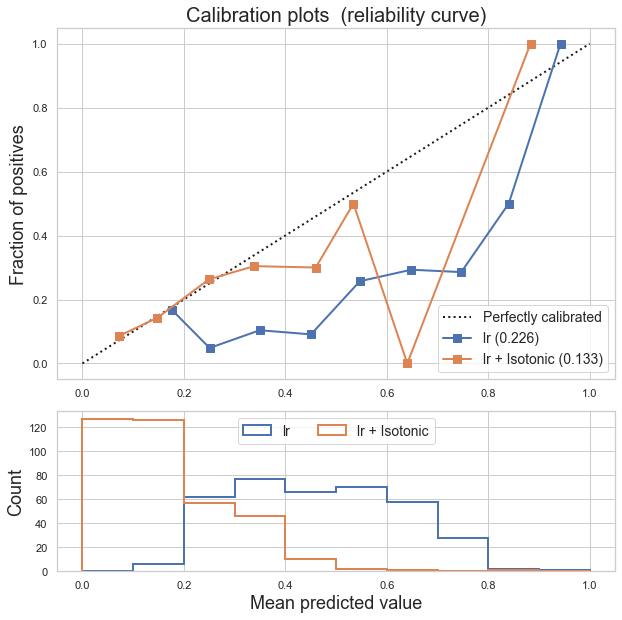

In [10]:
from sklearn.linear_model import LogisticRegression

lr_param_grid = {
  'lr__C': np.logspace(-3, 2, 6),
  'lr__intercept_scaling': [1], 
  'lr__max_iter': [100],
  'lr__penalty':  ['l1', 'l2'],
  'lr__solver': ['liblinear'], #good for small datasets
  'lr__tol': [0.0001],
  'lr__class_weight': [None, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}, 'balanced']

}

#
#0.694
result = evaluate_model(X_train, y_train, 'lr', 
                        LogisticRegression(), 
                        lr_param_grid, 
                        scorer, n_iter=n_iter, 
                        cv_folds=5, pipeline=pipeline2)
results.append(result)
res_cv[result[1]] = get_cv_scores(result[0])
res_calibrated[result[1]] = plot_calibration_curve(result[0], X_train, X_test, y_train, y_test, plot_=False)

**SGD Classifier**

* Exp 1.11 - best sgd score (AUC): ``0.658``
* Exp 1.11 - Precision C1: ``0.270`` (31)
* Exp 1.11 (Iso) - best sgd score (AUC): ``0.659``
* Exp 1.11 (Iso) - Precision C1: ``0.750`` (3)

==> Starting 5-fold cross validation for sgd model, 1479 examples
Fitting 5 folds for each of 100 candidates, totalling 500 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:    0.7s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:    3.9s
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:    9.5s
[Parallel(n_jobs=-1)]: Done 280 tasks      | elapsed:   16.5s
[Parallel(n_jobs=-1)]: Done 442 tasks      | elapsed:   25.5s
[Parallel(n_jobs=-1)]: Done 500 out of 500 | elapsed:   29.4s finished


==> Elapsed seconds: 29.437
Best sgd model: SGDClassifier(alpha=0.01, average=False, class_weight='balanced',
              early_stopping=False, epsilon=0.1, eta0=0.0, fit_intercept=True,
              l1_ratio=0.15, learning_rate='optimal', loss='log', max_iter=1000,
              n_iter_no_change=5, n_jobs=-1, penalty='l2', power_t=0.5,
              random_state=None, shuffle=True, tol=0.001,
              validation_fraction=0.1, verbose=0, warm_start=False)
Best sgd score (val): 0.640

======== sgd (test):
>Brier Score: 0.149
>ROC AUC: 0.633
>Precision class 1: 0.276
              precision    recall  f1-score   support

           0       0.84      0.93      0.88       307
           1       0.28      0.13      0.17        63

    accuracy                           0.79       370
   macro avg       0.56      0.53      0.53       370
weighted avg       0.74      0.79      0.76       370

Confusion matrix:
[[286  21]
 [ 55   8]]


======== sgd + Isotonic (test):
>Brier Score: 0.13

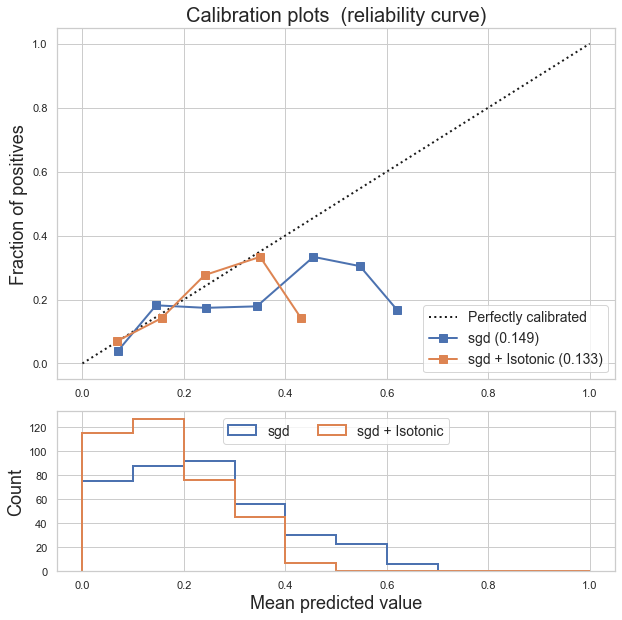

In [11]:
from sklearn.linear_model import SGDClassifier
sgd_param_grid = {
  'sgd__alpha' : np.logspace(-4, 3, 8), 
  'sgd__loss' : ['log'], #['log','hinge'],
  'sgd__max_iter' : [1000],  
  'sgd__n_jobs' : [-1], 
  'sgd__penalty' : ['l2', 'l1', 'elasticnet'],
  'sgd__tol' : [0.001],
  'sgd__class_weight': [None, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}, 'balanced']
}

#0.694=>0.747
result = evaluate_model(X_train, y_train, 'sgd', 
                        SGDClassifier(), 
                        sgd_param_grid, 
                        scorer, n_iter=n_iter, 
                        cv_folds=5, pipeline=pipeline2)
results.append(result)
res_cv[result[1]] = get_cv_scores(result[0])
res_calibrated[result[1]] = plot_calibration_curve(result[0], X_train, X_test, y_train, y_test, plot_=False)

**XGBoost**

* Exp 1.11 - best xgb score (AUC): ``0.742``
* Exp 1.11 - Precision C1: ``0.333`` (33)
* Exp 1.11 (Iso) - best xgb score (AUC): ``0.603``
* Exp 1.11 (Iso) - Precision C1: ``0.846`` (11)

==> Starting 5-fold cross validation for xgb model, 1479 examples
==> Elapsed seconds: 670.824
Best xgb model: XGBClassifier(base_score=0.5, booster=None, colsample_bylevel=1.0,
              colsample_bynode=1, colsample_bytree=0.6,
              gamma=0.6264873321658209, gpu_id=-1, importance_type='gain',
              interaction_constraints=None, learning_rate=0.10688899659609023,
              max_delta_step=0, max_depth=12, min_child_weight=10, missing=nan,
              monotone_constraints=None, n_estimators=400, n_jobs=0,
              num_parallel_tree=1, objective='binary:logistic', random_state=0,
              reg_alpha=0.27964976275250364, reg_lambda=0.01,
              scale_pos_weight=5756, subsample=1.0, tree_method=None,
              validate_parameters=False, verbosity=None)
Best xgb score (val): 0.741

======== xgb (test):
>Brier Score: 0.196
>ROC AUC: 0.738
>Precision class 1: 0.343
              precision    recall  f1-score   support

           0       0.89    

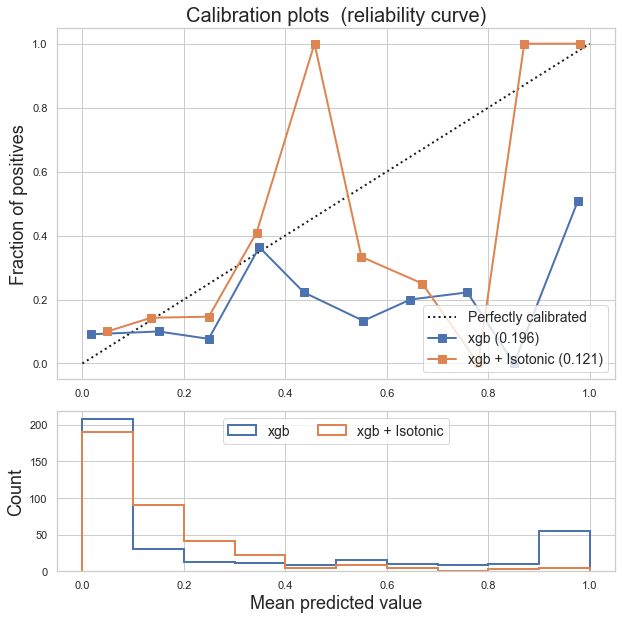

In [12]:
from xgboost import XGBClassifier

#skopt
xgb_param_grid = {
        'xgb__colsample_bylevel' : Real(1e-1, 1, 'uniform'),
        'xgb__colsample_bytree' : Real(6e-1, 1, 'uniform'),
        'xgb__gamma' :  Real(5e-1, 6, 'log-uniform'),
        'xgb__learning_rate' : Real(10**-5, 10**0, "log-uniform"),
        'xgb__max_depth' : Integer(1, 25, 'uniform'),
        'xgb__min_child_weight' : Integer(1, 10, 'uniform'),
        'xgb__n_estimators' : Integer(50, 400, 'log-uniform'),
        'xgb__reg_alpha' : Real(1e-2, 1, 'log-uniform'),
        'xgb__reg_lambda' : Real(1e-2, 1, 'log-uniform'),
        'xgb__subsample' : Real(6e-1, 1, 'uniform'),
        'xgb__scale_pos_weight' : Integer(1, 10000, 'log-uniform')
        
}




#0.829
result = evaluate_model_skopt(X_train, y_train, 'xgb', 
                        XGBClassifier(), 
                        xgb_param_grid, 
                        scorer, n_iter=n_iter, 
                        cv_folds=5, pipeline=pipeline2)
results.append(result)
res_cv[result[1]] = get_cv_scores(result[0])
res_calibrated[result[1]] = plot_calibration_curve(result[0], X_train, X_test, y_train, y_test, plot_=False)

**Light GBM**

* Exp 1.11 - best lgbm score (AUC): ``0.732``
* Exp 1.11 - Precision C1: ``0.625`` (15)
* Exp 1.11 (Iso) - best lgbm score (AUC): ``0.703``
* Exp 1.11 (Iso) - Precision C1: ``0.526`` (20)

==> Starting 5-fold cross validation for lgbm model, 1479 examples
==> Elapsed seconds: 468.754
Best lgbm model: LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=0.6,
               importance_type='split', is_unbalance=True, learning_rate=1.0,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=3,
               objective=None, random_state=None, reg_alpha=0.001,
               reg_lambda=1.0, silent=True, subsample=0.5455354070101484,
               subsample_for_bin=172011, subsample_freq=0)
Best lgbm score (val): 0.711

======== lgbm (test):
>Brier Score: 0.170
>ROC AUC: 0.709
>Precision class 1: 0.333
              precision    recall  f1-score   support

           0       0.88      0.82      0.85       307
           1       0.33      0.43      0.38        63

    accuracy                           0.76       370
   macro avg       0.60      0.63      0.61   

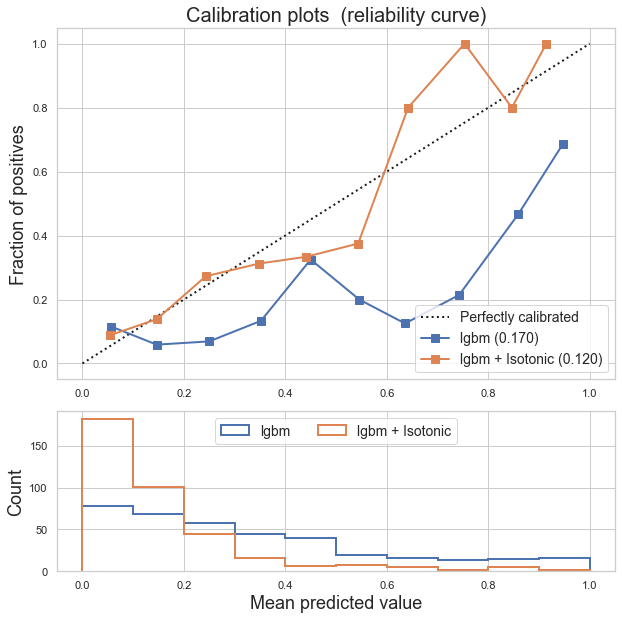

In [13]:
from lightgbm import LGBMClassifier
lgbm_param_grid = {
    'lgbm__boosting_type': Categorical(['gbdt', 'goss', 'dart']),
    'lgbm__num_leaves':  Integer(2, 10, 'uniform'),
    'lgbm__learning_rate': Real(10**-5, 10**0, "log-uniform"),
    'lgbm__subsample_for_bin': Integer(20000, 300000, 'log-uniform'),
    'lgbm__min_child_samples': Integer(20, 500, 'uniform'),
    'lgbm__reg_alpha': Real(10**-3, 10**0, "log-uniform"),
    'lgbm__reg_lambda': Real(10**-3, 10**0, "log-uniform"),
    'lgbm__colsample_bytree': Real(6e-1, 1, 'uniform'),
    'lgbm__subsample': Real(5e-1, 1, 'uniform'),
    'lgbm__is_unbalance': Categorical([True, False]),
    'lgbm__class_weight': Categorical([None, 'balanced'])

}


#0.811=>0.822 
result = evaluate_model_skopt(X_train, y_train, 'lgbm',
                        LGBMClassifier(),
                        lgbm_param_grid, 
                        scorer, n_iter=n_iter, 
                        cv_folds=5, pipeline=pipeline2)
results.append(result)
res_cv[result[1]] = get_cv_scores(result[0])
res_calibrated[result[1]] = plot_calibration_curve(result[0], X_train, X_test, y_train, y_test, plot_=False)

**Random Forest**

Rather than Knn, which performed poor results, we will try another ensemble model.

==> Starting 5-fold cross validation for rf model, 1479 examples
Fitting 5 folds for each of 50 candidates, totalling 250 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 4 concurrent workers.
[Parallel(n_jobs=-1)]: Done  10 tasks      | elapsed:   11.1s
[Parallel(n_jobs=-1)]: Done  64 tasks      | elapsed:  1.2min
[Parallel(n_jobs=-1)]: Done 154 tasks      | elapsed:  2.9min
[Parallel(n_jobs=-1)]: Done 250 out of 250 | elapsed:  4.3min finished


==> Elapsed seconds: 264.258
Best rf model: RandomForestClassifier(bootstrap=False, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=40, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=800,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Best rf score (val): 0.605

======== rf (test):
>Brier Score: 0.122
>ROC AUC: 0.748
>Precision class 1: 0.611
              precision    recall  f1-score   support

           0       0.85      0.98      0.91       307
           1       0.61      0.17      0.27        63

    accuracy                           0.84       370
   macro avg       0.73      0.58      0.59       370
weighted avg       0.81     

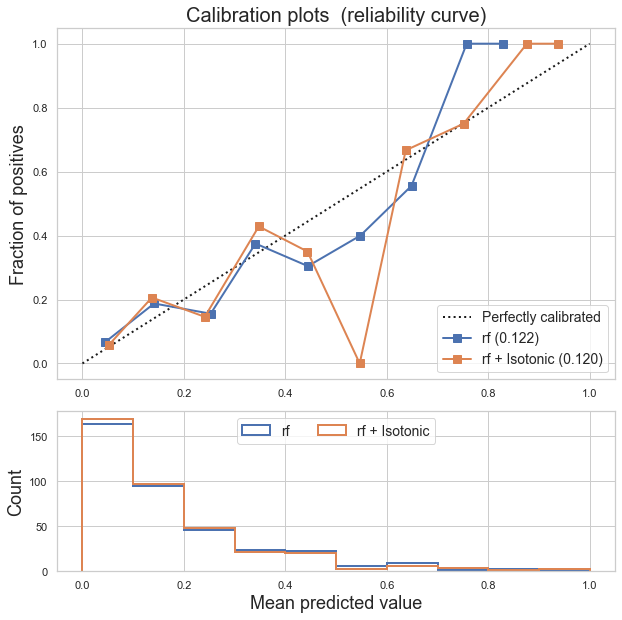

In [14]:
from sklearn.ensemble import RandomForestClassifier


rf_param_grid =  {
    'rf__bootstrap' : [True, False],
    #'rf__class_weight': [None, {0:1,1:1}, {0:1,1:10}, {0:1,1:100}, 'balanced'],
    'rf__max_depth' : [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None], 
    'rf__max_features' : ['auto', 'sqrt'],
    'rf__min_samples_leaf' : [1, 2, 4],
    'rf__min_samples_split' : [2, 5, 10],
    'rf__n_estimators' : [200, 400, 600, 800, 1000]
}



result = evaluate_model(X_train, y_train, 'rf', 
                        RandomForestClassifier(), 
                        rf_param_grid, 
                        scorer, n_iter=n_iter, 
                        cv_folds=5, pipeline=pipeline2)

results.append(result)
res_cv[result[1]] = get_cv_scores(result[0])
res_calibrated[result[1]] = plot_calibration_curve(result[0], X_train, X_test, y_train, y_test, plot_=False)
mdl = list(filter(lambda x: x[1] == 'rf', results))[0][0]
#mdl.save('../models_pkl/experiment-2.0_RF_SHAP-model.pkl')

* Below the diagonal: The model has over-forecast; the probabilities are too large.
* Above the diagonal: The model has under-forecast; the probabilities are too small.

#### Comparing results (validation scores)

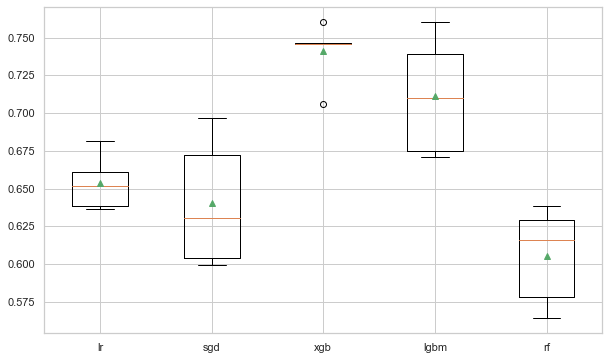

In [15]:
_ = plt.boxplot(res_cv.values(), labels=res_cv.keys(), showmeans=True)

##### Calibrated Results (TEST SET)

In [16]:
pd.DataFrame.from_dict(list(map(lambda x:
                      {'model': res_calibrated[x][1], 'mean': res_calibrated[x][2], 'precision_c1': res_calibrated[x][3]},
                                res_calibrated)))[['model', 'mean', 'precision_c1'
                                ]].sort_values('mean', ascending=False)#.style.bar()

,model,mean,precision_c1
4,rf + Isotonic,0.753089,0.666667
2,xgb + Isotonic,0.737552,0.523810
3,lgbm + Isotonic,0.725247,0.666667
1,sgd + Isotonic,0.692725,0.000000
0,lr + Isotonic,0.691665,0.500000


The best model was **Light GBM**. We will save it to use later on.

In [17]:
model = list(filter(lambda x: x[1] == 'lgbm', results))[0][0]
cal_model = res_calibrated['lgbm']
print('Best calibrated model performance mean:', cal_model[2])
print('Best calibrated model performance C1:', cal_model[3])
#model.save('../models_pkl/experiment-2.0-model.pkl')

Best calibrated model performance mean: 0.7252468848560054
Best calibrated model performance C1: 0.6666666666666666


--------------
-------------

### Analyzing best model

In [18]:
model = Model.load('../models_pkl/experiment-2.0-model.pkl')
#model = list(filter(lambda x: x[1] == 'lgbm', results))[0][0]
model.model

LGBMClassifier(boosting_type='dart', class_weight=None, colsample_bytree=0.6,
               importance_type='split', is_unbalance=True, learning_rate=1.0,
               max_depth=-1, min_child_samples=20, min_child_weight=0.001,
               min_split_gain=0.0, n_estimators=100, n_jobs=-1, num_leaves=3,
               objective=None, random_state=None, reg_alpha=0.001,
               reg_lambda=1.0, silent=True, subsample=0.5455354070101484,
               subsample_for_bin=172011, subsample_freq=0)

The learning curve may suggest some overfiting, however the linear models which shows a funnel shape curve, had very poor results on test set.

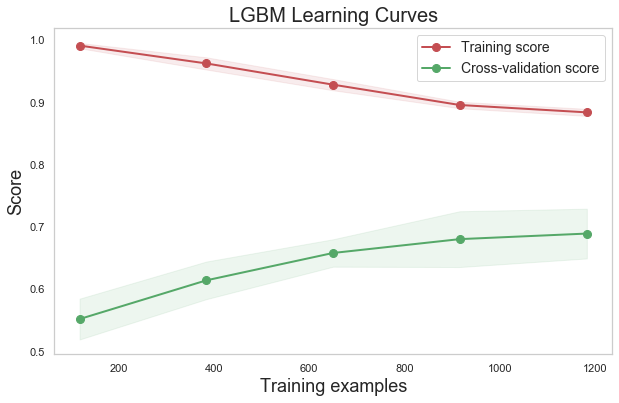

In [19]:
plot_learning_curve(model.model, 
                    model.name.upper()+' Learning Curves',
                    model.pipeline.fit_transform(X_train), y_train,
                    cv=5, scoring=scorer)

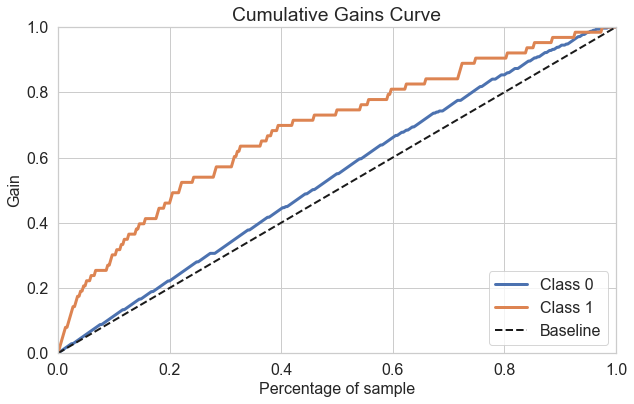

In [20]:
preds, probs = model.predict_calibrated(X_test, X_train, y_train)
#preds = model.model.predict(model.pipeline.transform(X_test))
#probs = model.model.predict_proba(model.pipeline.transform(X_test))
_ = skplt.metrics.plot_cumulative_gain(y_test, probs)

Our best model LGBM (iso), performed decent results all considered metrics, pretty close from the best model with the leaky feature.

* Brier Score: 0.120
* ROC AUC: 0.725
* Precision class 1: 0.667

              precision    recall  f1-score   support

           0       0.86      0.98      0.91       307
           1       0.67      0.22      0.33        63

    accuracy                           0.85       370
   macro avg       0.76      0.60      0.62       370
weighted avg       0.83      0.85      0.82       370



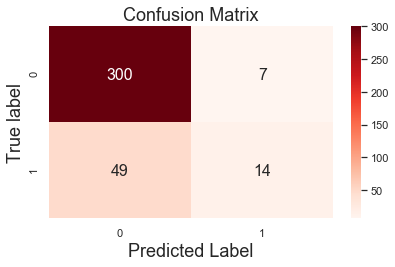

In [21]:
plot_confusion_matrix(y_test, preds)

#### Feature Importance

> The new pipeline, which removed leaky and high corr features, presented feature importances much more aligned with our business expectations with `Employees` and `Account_ICP_Score`, among them.

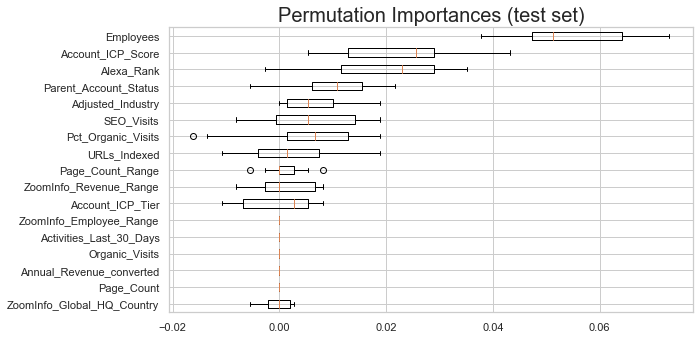

In [22]:
plot_feature_permutation(pipeline2, model.model, X_train, y_train, X_test, y_test)

#### SHAP

In [23]:
import shap
shap.initjs()

In [48]:
X_transf_train = mdl.pipeline.transform(X_train)
X_transf_test = mdl.pipeline.transform(X_test)

DEL_PIPE_2  = set(['ZoomInfo_Employee_Range'] + experiment_2.DEL_NUM_PIPE2)
X_transf_cols = list(set(X.columns) - DEL_PIPE_2)

X_display_train = X_train[X_transf_cols]
X_display_test = X_test[X_transf_cols]

In [25]:
mdl = Model.load('../models_pkl/experiment-2.0_RF_SHAP-model.pkl')
explainer = shap.TreeExplainer(mdl.model)

In [60]:
#plot_feature_permutation(pipeline2, mdl.model, X_train, y_train, X_test, y_test)

In [49]:
shap_values = explainer.shap_values(X_transf_train)
explainer.expected_value

array([0.8296146, 0.1703854])

In [52]:
shap.force_plot(explainer.expected_value[1], shap_values[1][839,:], X_display_train.iloc[839,:])

In [53]:
shap.force_plot(explainer.expected_value[1], shap_values[1][0,:], X_display_train.iloc[0,:])

In [54]:
shap.force_plot(explainer.expected_value[1], shap_values[1], X_display_train)

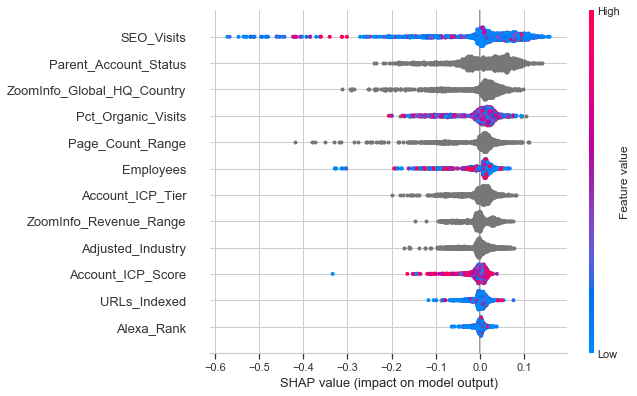

In [55]:
shap.summary_plot(shap_values[0], X_display_train)

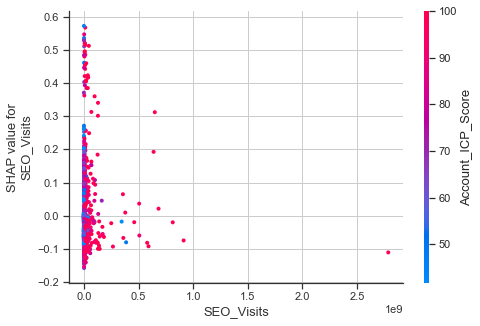

In [61]:
shap.dependence_plot("SEO_Visits", shap_values[1], X_display_train, interaction_index="Account_ICP_Score")

-------------
-------------

### Financial Impact of the Best Model

In [57]:
n_instances = len(X)
p_instances = y.sum() / len(y)
p_targeted = 0.1
n_targeted = int(n_instances*p_targeted)
n_targeted_test = int(len(X_test) * p_targeted)

              precision    recall  f1-score   support

         0.0       0.69      0.61      0.65        18
         1.0       0.67      0.74      0.70        19

    accuracy                           0.68        37
   macro avg       0.68      0.67      0.67        37
weighted avg       0.68      0.68      0.67        37



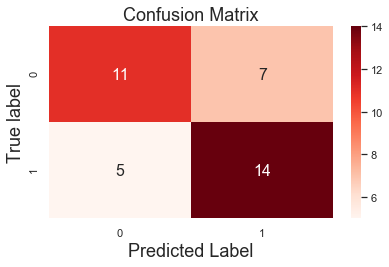

In [58]:
# Create a dataframe of probabilities and actual / predicted outcomes
probs_df = pd.DataFrame(np.hstack([probs, y_test.values.reshape(-1,1), preds.reshape(-1,1)]), 
                        columns=['p_no', 'p_yes', 'actual', 'predicted'])


# Sort customers by the probability that they will convert
model_targets = probs_df.sort_values('p_yes', ascending=False)

# Take the top 10%
model_targets = model_targets.head(n_targeted_test)

# Calculate precision matrix
plot_confusion_matrix(model_targets.actual, model_targets.predicted)

Picking the top 10% fo our model prediction, the precision went down 6% (~84%) from exp1.0.

In [59]:
# Setup costs and benefits
avg_revenue = params.AVG_REVENUE
avg_cost = params.AVG_COST

# Calculate financial outcomes
random_profit = experiment_1.get_model_profit(X_test, y_test, n_targeted_test, avg_revenue, avg_cost, experiment_1.random_model_predictions)
baseline_profit = experiment_1.get_model_profit(X_test, y_test, n_targeted_test, avg_revenue, avg_cost, experiment_1.baseline_model_predictions)
model_profit = experiment_1.get_model_profit(X_test, y_test, n_targeted_test, avg_revenue, avg_cost, preds=model_targets.actual)

print('Number of customers targeted: {:,}/{:,}'.format(len(model_targets), len(X_test)))
print('Conversion rate of model policy: {:.2f}%'.format(model_targets.actual.sum() / len(y_test)*100.))
print('Expected profit of model policy: ${:,}'.format(model_profit))
print('Lift over random: {:.1f} or ${:,}'.format(model_profit / random_profit, model_profit - random_profit))
print('Lift over baseline: {:.1f} or ${:,}'.format(model_profit / baseline_profit, model_profit - baseline_profit))

Number of customers targeted: 37/370
Conversion rate of model policy: 5.14%
Expected profit of model policy: $18,630
Lift over random: 3.3 or $13,000
Lift over baseline: 1.5 or $6,000
